In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
import dictionaries
import omnifoldHI

import ibu
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
dict_data        = dictionaries.load('../analysis/dict_data_h110_p000.pkl')
multifoldHI_out  = dictionaries.load('../analysis/multifoldHI_out_h110_p000_mfHI18.pkl')
dict_multifoldHI = omnifoldHI.create_dict_multifoldHI(dict_data,
                                                      multifoldHI_out['weights_stat'],
                                                      multifoldHI_out['weights_syst'],
                                                      multifold_it=-1,
                                                      norm_use_F=False)

Unpickled: ../analysis/dict_data_h110_p000.pkl
Unpickled: ../analysis/multifoldHI_out_h110_p000_mfHI18.pkl


0 0
Error data and bins are incompatible 1566428 22


TypeError: 'NoneType' object is not subscriptable

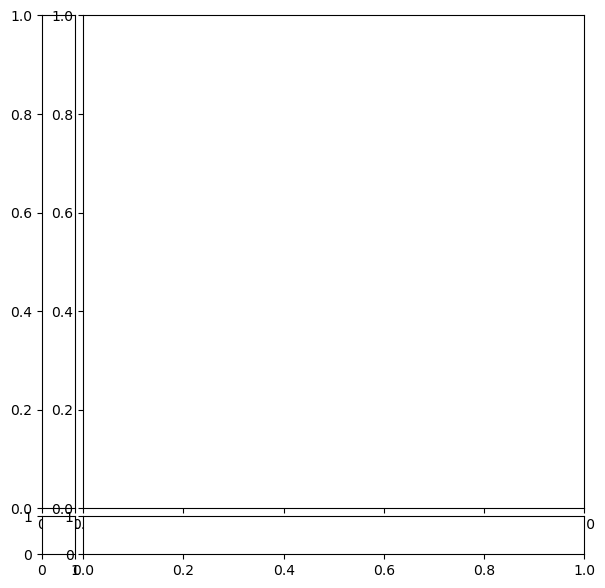

In [29]:
with PdfPages('temp.pdf') as pdf:
    for i,ikey in enumerate(dict_data):
        for j,jkey in enumerate(dict_data):
            if i>1 or j>1: break
            print(i,j)
            fig, ax = plt.subplots(2,2, figsize=(7,7), height_ratios=(13,1), width_ratios=(1,15), gridspec_kw={'hspace': 0.03, 'wspace': 0.03})
            
            xbinsi = dict_data[ikey]['bins_E']
            xbinsj = dict_data[jkey]['bins_C']
            h1 = ibu.response([dict_data[ikey]['evs_syn_E'].tolist(),dict_data[jkey]['evs_syn_C'].tolist()], [xbinsi.tolist(), xbinsj.tolist()])
            h1[0] *= np.diff(h1[-2])[:,None]
            
            X, Y = np.meshgrid(h1[-1][:,np.newaxis], h1[-2])
            ax[0,1].pcolormesh(X.T[1:,1:], Y.T[1:,1:], h1[0].T[1:,1:], norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1))
            X0 = np.array([np.zeros(nbinsi+1),np.ones(nbinsi+1)])
            im = ax[0,0].pcolormesh(X0, Y.T[:2,:], h1[0].T[:1,:], norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1))
            Y0 = np.array([np.zeros(nbinsj+1),np.ones(nbinsj+1)]).T
            ax[1,1].pcolormesh(X.T[:,:2], Y0, h1[0].T[:,:1], norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1))
            ax[1,0].pcolormesh([[0,0],[1,1]], [[0,1],[0,1]], h1[0].T[:1,:1], norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1))
            
            ax[1,0].set_xticks(ticks=[0.5], labels=[r'$F$'])
            ax[1,0].set_yticks(ticks=[0.5], labels=[r'$T$'])
            ax[0,0].tick_params(axis='both',which='both', right=True, top=True, bottom=True, labelbottom=False, direction='in', labelsize=16)
            ax[1,0].tick_params(axis='both',which='both', right=True, top=True, bottom=True, direction='in', labelsize=16)
            ax[0,1].tick_params(axis='both',which='both', right=True, top=True, bottom=True, labelleft=False, labelbottom=False, direction='in', labelsize=16)
            ax[1,1].tick_params(axis='both',which='both', right=True, top=True, bottom=True, labelleft=False, direction='in', labelsize=16)
            ax[0,0].set_xlim(0,1)
            ax[0,0].set_ylim(dict_data[ikey]['xlim_E'])
            ax[1,0].set_ylim(0,1)
            ax[1,0].set_xlim(0,1)
            ax[0,1].set_xlim(dict_data[jkey]['xlim_C'])
            ax[0,1].set_ylim(dict_data[ikey]['xlim_E'])
            ax[1,1].set_xlim(dict_data[jkey]['xlim_C'])
            ax[1,1].set_ylim(0,1)
            ax[0,0].set_ylabel('Measured: '+ dict_data[ikey]['xlabel'], fontsize=16)
            ax[1,1].set_xlabel('Truth: '+dict_data[jkey]['xlabel'], fontsize=16)
            cb = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.01, aspect=50)
            cb.set_label(r'$P(E_j|C_i)$', fontsize=16)
#             fig.text(0.935, 0.625, r'Truth: Herwig7 generated', color='Silver', rotation=-90)
#             fig.text(0.905, 0.510, r'Measured: Herwig7 + Delphes' , color='Silver', rotation=-90)
            fig.tight_layout()
            pdf.savefig()
            plt.close()     

In [3]:
def plot_multifold (obs_dict_multifoldHI, axy, axr, axFTy, axFTr, style):

    cmap = plt.get_cmap('YlOrRd')

    hist_style = {f'multifold{d}': {'stat':{'color':cmap((d+5)/(18+5)), 'label':f'OmniFold-HI {d}D', 'lw':1.5, 'capsize':2},
                   'syst':{'color':cmap((d+5)/(18+5)), 'alpha':.3}} for d in range(1,18)}

    hist_style['multifold18'] = {'stat':{'color':'crimson', 'label':f'OmniFold-HI 18D', 'lw':1.5, 'capsize':2},
                                 'syst':{'color':'crimson', 'alpha':.3}}

    # omnifold (original)
    # Plot unfolded
    axy.errorbar(obs_dict_multifoldHI['midbin_C'], obs_dict_multifoldHI['hist_unf_C'], obs_dict_multifoldHI['hist_unf_C_unc_stat'], obs_dict_multifoldHI['midbin_C_unc'], fmt=',', **hist_style[style]['stat'])
    axy.bar(obs_dict_multifoldHI['midbin_C'], 2*obs_dict_multifoldHI['hist_unf_C_unc_stat'], 2*obs_dict_multifoldHI['midbin_C_unc'], obs_dict_multifoldHI['hist_unf_C']-obs_dict_multifoldHI['hist_unf_C_unc_stat'], **hist_style[style]['syst'])

    ###
    # Compute unfolded raito to truth
    omn_tru          = (obs_dict_multifoldHI['hist_unf_C']+1e-10)/(obs_dict_data['hist_nat_C']+1e-10)
    omn_tru_unc_stat = (obs_dict_multifoldHI['hist_unf_C_unc_stat'])/(obs_dict_data['hist_nat_C']+1e-10)
    omn_tru_unc_syst = (obs_dict_multifoldHI['hist_unf_C_unc_syst'])/(obs_dict_data['hist_nat_C']+1e-10)

    ###
    # Plot unfolded ratio to truth
    axr.errorbar(obs_dict_multifoldHI['midbin_C'], omn_tru, omn_tru_unc_stat, obs_dict_multifoldHI['midbin_C_unc'], **hist_style[style]['stat'])
    axr.bar(obs_dict_multifoldHI['midbin_C'], 2*omn_tru_unc_syst, 2*obs_dict_multifoldHI['midbin_C_unc'], omn_tru-omn_tru_unc_syst, **hist_style[style]['syst'])

    ###
    # Plot unfolded fake
    axFTy.errorbar([1], obs_dict_multifoldHI['hist_unf_F'], obs_dict_multifoldHI['hist_unf_F_unc_stat'], [.4], **hist_style[style]['stat'])
    axFTy.bar([1], 2*obs_dict_multifoldHI['hist_unf_F_unc_stat'], [2*.4], obs_dict_multifoldHI['hist_unf_F']-obs_dict_multifoldHI['hist_unf_F_unc_stat'], **hist_style[style]['syst'])

    ###
    # Compute unfolded fake ratio to truth
    fake_omn_tru          = (obs_dict_multifoldHI['hist_unf_F']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)
    fake_omn_tru_unc_stat = (obs_dict_multifoldHI['hist_unf_F_unc_stat']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)
    fake_omn_tru_unc_syst = (obs_dict_multifoldHI['hist_unf_F_unc_syst']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)

    ###
    # Plot unfolded fake ratio to truth
    axFTr.errorbar([1], fake_omn_tru, fake_omn_tru_unc_stat, [.4], **hist_style[style]['stat'])
    axFTr.bar([1], 2*fake_omn_tru_unc_syst, [2*.4], fake_omn_tru-fake_omn_tru_unc_syst, **hist_style[style]['syst'])

    ###
    # Plot unfolded trash
    axFTy.errorbar([2], obs_dict_multifoldHI['hist_unf_T'], obs_dict_multifoldHI['hist_unf_T_unc_stat'], [.4], **hist_style[style]['stat'])
    axFTy.bar([2], 2*obs_dict_multifoldHI['hist_unf_T_unc_stat'], [2*.4], obs_dict_multifoldHI['hist_unf_T']-obs_dict_multifoldHI['hist_unf_T_unc_stat'], **hist_style[style]['syst'])

    ###
    # Compute unfolded trash ratio to truth
    tras_omn_dat          = (obs_dict_multifoldHI['hist_unf_T']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)
    tras_omn_dat_unc_stat = (obs_dict_multifoldHI['hist_unf_T_unc_stat']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)
    tras_omn_dat_unc_syst = (obs_dict_multifoldHI['hist_unf_T_unc_syst']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)

    ###
    # Plot unfolded trash ratio to truth
    axFTr.errorbar([2], tras_omn_dat, tras_omn_dat_unc_stat, [.4], **hist_style[style]['stat'])
    axFTr.bar([2], 2*tras_omn_dat_unc_syst, [2*.4], tras_omn_dat-tras_omn_dat_unc_syst, **hist_style[style]['syst'])

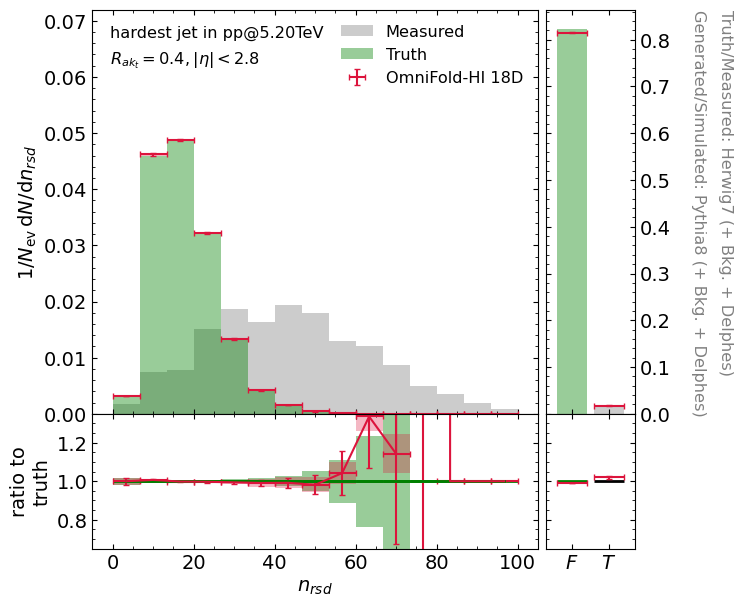

In [4]:
plot_obs = ["n_RSD"]

nature_label = 'Herwig7 (+ Bkg. + Delphes)'
synthetic_label = 'Pythia8 (+ Bkg. + Delphes)'

with mpl.rc_context({'font.family': 'sans-serif', 'font.size': 14, 'text.usetex':False}):

    hist_style = {
        'gen': {'label':'gen', 'lw':2, 'color':'royalblue'},
        'sim': {'label':'sim', 'lw':2, 'color':'orange'},
        'tru': {'label':'Truth', 'lw':2, 'color':'green'},
        'dat': {'label':'dat', 'lw':2, 'color':'k'}
    }

    # Create figure and grid
    fig = plt.figure(figsize=(7,7))
    gs_main = fig.add_gridspec(1, 1)

    # Plot for each observable
    axes = []
    for i, key in enumerate(plot_obs):

        obs_dict_data = dict_data[key]

        #fig = plt.figure(figsize=(7,6))

        gs = gs_main[i].subgridspec(2,2, height_ratios=(3,1), width_ratios=(5,1), hspace=0, wspace=.03)

        axy   = fig.add_subplot(gs[0,0])
        axr   = fig.add_subplot(gs[1,0], sharex=axy)
        axFTy = fig.add_subplot(gs[0,1])
        axFTr = fig.add_subplot(gs[1,1], sharex=axFTy, sharey=axr)
        axes.append({'axy':axy, 'axr':axr, 'axFTy':axFTy, 'axFTr':axFTr})

        # BASELINE
        ## Plot datasets
        axy.stairs(obs_dict_data['hist_nat_E'], obs_dict_data['bins_E'], baseline=0, fill=True, alpha=.2, color='k', label='Measured')
        axy.stairs(obs_dict_data['hist_nat_C'], obs_dict_data['bins_C'], baseline=0, fill=True, alpha=.4, color='green', label='Truth')

        ###
        # Plot fake
        axFTy.stairs(obs_dict_data['hist_nat_F'], [.6,1.4], baseline=0, fill=True, alpha=.4, color='green')

        ###
        # Plot trash
        axFTy.stairs(obs_dict_data['hist_nat_T'], [1.6,2.4], baseline=0, fill=True, alpha=.2, color='k')

        ###
        # Compute raito to truth
        tru_tru     = (obs_dict_data['hist_nat_C']+1e-10)/(obs_dict_data['hist_nat_C']+1e-10)
        tru_tru_std = (obs_dict_data['hist_nat_C_unc'])/(obs_dict_data['hist_nat_C']+1e-10)

        ###
        # Plot ratio to truth
        axr.errorbar(obs_dict_data['midbin_C'], np.ones(len(obs_dict_data['bins_C'])-1), 0,obs_dict_data['midbin_C_unc'], **hist_style['tru'])
        axr.stairs(tru_tru+tru_tru_std, obs_dict_data['bins_C'], baseline=1, fill=True, alpha=.4, color='green')
        axr.stairs(tru_tru-tru_tru_std, obs_dict_data['bins_C'], baseline=1, fill=True, alpha=.4, color='green')

        ###
        # Compute fake ratio to truth
        fake_tru_tru     = (obs_dict_data['hist_nat_F']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)
        fake_tru_tru_std = (obs_dict_data['hist_nat_F_unc']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)

        ###
        # Plot fake ratio to truth
        axFTr.errorbar([1], [1], 0, [.4], **hist_style['tru'])
        axFTr.stairs(fake_tru_tru-fake_tru_tru_std, [.6,1.4], baseline=1, fill=True, alpha=.4, color='green')
        axFTr.stairs(fake_tru_tru+fake_tru_tru_std, [.6,1.4], baseline=1, fill=True, alpha=.4, color='green')

        ###
        # Compute trash ratio to truth
        tras_dat_dat     = (obs_dict_data['hist_nat_T']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)
        tras_dat_dat_std = (obs_dict_data['hist_nat_T_unc']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)

        ###
        # Plot trash ratio to truth
        axFTr.errorbar([2], [1], 0, [.4], **hist_style['dat'])
        axFTr.stairs(fake_tru_tru-fake_tru_tru_std, [1.6,2.4], baseline=1, fill=True, alpha=.2, color='k')
        axFTr.stairs(fake_tru_tru+fake_tru_tru_std, [1.6,2.4], baseline=1, fill=True, alpha=.2, color='k')

        # MULTIFOLD
        plot_multifold(dict_multifoldHI[key], axy, axr, axFTy, axFTr, style='multifold18')

        # Labels and limits
        axr.set_xlabel(obs_dict_data['xlabel'])
        axy.set_ylabel(obs_dict_data['ylabel'])
        axr.set_ylabel('ratio to\ntruth')
        axFTr.set_ylim(.65,1.35)
        axFTr.set_xlim(.3,2.7)
        
        # Ticks
        axFTr.set_xticks(ticks=[1,2], labels=[r'$F$',r'$T$'])
        axFTr.set_yticks(ticks=[.8,1,1.2])
        for axis in [axy,axr,axFTy,axFTr]:
            axis.minorticks_on()
            axis.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        for axis in [axFTy, axFTr]:
            axis.tick_params(axis='x', which='minor', top=False, bottom=False)
        for axis in [axy, axFTy]:
            axis.tick_params(axis='x', labelbottom=False)
        for axis in [axFTy]:
            axis.tick_params(axis='y', labelleft=False)
            axis.tick_params(axis='y', labelright=True)
        for axis in [axFTr]:
            axis.tick_params(axis='y', labelleft=False)
            axis.tick_params(axis='y', labelright=False)

    axes[-1]['axFTy'].text(2.1,1, f'Truth/Measured: {nature_label}', color='gray', fontsize='small', ha='right', va='top', transform=axes[-1]['axFTy'].transAxes, rotation=-90)
    axes[-1]['axFTy'].text(1.8,1, f'Generated/Simulated: {synthetic_label}', color='gray', fontsize='small', ha='right', va='top', transform=axes[-1]['axFTy'].transAxes, rotation=-90)

    axes[0]['axy'].text(.04,.96, r'hardest jet in pp@5.20TeV', fontsize='small', ha='left', va='top', transform=axes[0]['axy'].transAxes)
    axes[0]['axy'].text(.04,.9, r'$R_{ak_t}=0.4, |\eta|<2.8$', fontsize='small', ha='left', va='top', transform=axes[0]['axy'].transAxes)

    axes[0]['axy'].set_ylim(0,.072)

    axes[0]['axy'].legend(frameon=False, fontsize='small', loc=1)

    #plt.savefig(f'../figures/omnifoldHI.pdf', bbox_inches='tight')
    plt.show()


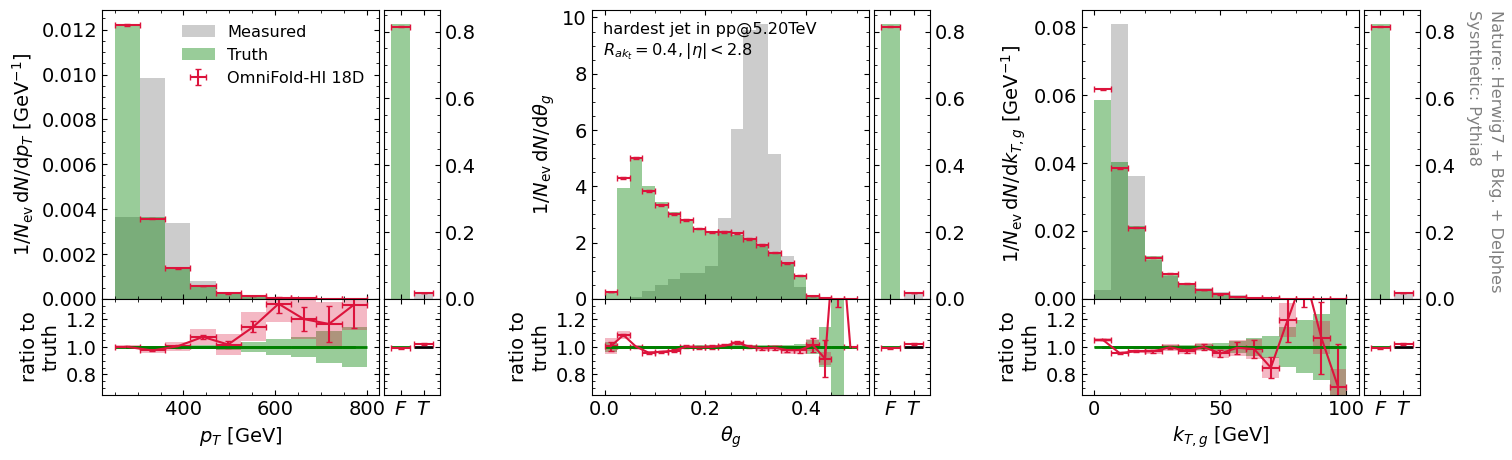

In [7]:
plot_obs = ["pt_jet", "th_DyG", "kt_DyG"]

nature_label = 'Herwig7 + Bkg. + Delphes'
synthetic_label = 'Pythia8'

with mpl.rc_context({'font.family': 'sans-serif', 'font.size': 14, 'text.usetex':False}):

    hist_style = {
        'gen': {'label':'gen', 'lw':2, 'color':'royalblue'},
        'sim': {'label':'sim', 'lw':2, 'color':'orange'},
        'tru': {'label':'Truth', 'lw':2, 'color':'green'},
        'dat': {'label':'dat', 'lw':2, 'color':'k'}
    }

    # Create figure and grid
    fig = plt.figure(figsize=(17,15/3*int(np.ceil(len(plot_obs)/3))))
    gs_main = fig.add_gridspec(int(np.ceil(len(plot_obs)/3)), 3, wspace=.45)

    # Plot for each observable
    axes = []
    for i, key in enumerate(plot_obs):

        obs_dict_data = dict_data[key]

        #fig = plt.figure(figsize=(7,6))

        gs = gs_main[i].subgridspec(2,2, height_ratios=(3,1), width_ratios=(5,1), hspace=0, wspace=.03)

        axy   = fig.add_subplot(gs[0,0])
        axr   = fig.add_subplot(gs[1,0], sharex=axy)
        axFTy = fig.add_subplot(gs[0,1])
        axFTr = fig.add_subplot(gs[1,1], sharex=axFTy, sharey=axr)
        axes.append({'axy':axy, 'axr':axr, 'axFTy':axFTy, 'axFTr':axFTr})

        # BASELINE
        ## Plot datasets
        axy.stairs(obs_dict_data['hist_nat_E'], obs_dict_data['bins_E'], baseline=0, fill=True, alpha=.2, color='k', label='Measured')
        axy.stairs(obs_dict_data['hist_nat_C'], obs_dict_data['bins_C'], baseline=0, fill=True, alpha=.4, color='green', label='Truth')

        ###
        # Plot fake
        axFTy.stairs(obs_dict_data['hist_nat_F'], [.6,1.4], baseline=0, fill=True, alpha=.4, color='green')

        ###
        # Plot trash
        axFTy.stairs(obs_dict_data['hist_nat_T'], [1.6,2.4], baseline=0, fill=True, alpha=.2, color='k')

        ###
        # Compute raito to truth
        tru_tru     = (obs_dict_data['hist_nat_C']+1e-10)/(obs_dict_data['hist_nat_C']+1e-10)
        tru_tru_std = (obs_dict_data['hist_nat_C_unc'])/(obs_dict_data['hist_nat_C']+1e-10)

        ###
        # Plot ratio to truth
        axr.errorbar(obs_dict_data['midbin_C'], np.ones(len(obs_dict_data['bins_C'])-1), 0,obs_dict_data['midbin_C_unc'], **hist_style['tru'])
        axr.stairs(tru_tru+tru_tru_std, obs_dict_data['bins_C'], baseline=1, fill=True, alpha=.4, color='green')
        axr.stairs(tru_tru-tru_tru_std, obs_dict_data['bins_C'], baseline=1, fill=True, alpha=.4, color='green')

        ###
        # Compute fake ratio to truth
        fake_tru_tru     = (obs_dict_data['hist_nat_F']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)
        fake_tru_tru_std = (obs_dict_data['hist_nat_F_unc']+1e-10)/(obs_dict_data['hist_nat_F']+1e-10)

        ###
        # Plot fake ratio to truth
        axFTr.errorbar([1], [1], 0, [.4], **hist_style['tru'])
        axFTr.stairs(fake_tru_tru-fake_tru_tru_std, [.6,1.4], baseline=1, fill=True, alpha=.4, color='green')
        axFTr.stairs(fake_tru_tru+fake_tru_tru_std, [.6,1.4], baseline=1, fill=True, alpha=.4, color='green')

        ###
        # Compute trash ratio to truth
        tras_dat_dat     = (obs_dict_data['hist_nat_T']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)
        tras_dat_dat_std = (obs_dict_data['hist_nat_T_unc']+1e-10)/(obs_dict_data['hist_nat_T']+1e-10)

        ###
        # Plot trash ratio to truth
        axFTr.errorbar([2], [1], 0, [.4], **hist_style['dat'])
        axFTr.stairs(fake_tru_tru-fake_tru_tru_std, [1.6,2.4], baseline=1, fill=True, alpha=.2, color='k')
        axFTr.stairs(fake_tru_tru+fake_tru_tru_std, [1.6,2.4], baseline=1, fill=True, alpha=.2, color='k')

        plot_multifold(dict_multifoldHI[key], axy, axr, axFTy, axFTr, style='multifold18')

        # Labels and limits
        axr.set_xlabel(obs_dict_data['xlabel'])
        axy.set_ylabel(obs_dict_data['ylabel'])
        axr.set_ylabel('ratio to\ntruth')
        axFTr.set_ylim(.65,1.35)
        axFTr.set_xlim(.3,2.7)
        
        # Ticks
        axFTr.set_xticks(ticks=[1,2], labels=[r'$F$',r'$T$'])
        axFTr.set_yticks(ticks=[.8,1,1.2])
        for axis in [axy,axr,axFTy,axFTr]:
            axis.minorticks_on()
            axis.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        for axis in [axFTy, axFTr]:
            axis.tick_params(axis='x', which='minor', top=False, bottom=False)
        for axis in [axy, axFTy]:
            axis.tick_params(axis='x', labelbottom=False)
        for axis in [axFTy]:
            axis.tick_params(axis='y', labelleft=False)
            axis.tick_params(axis='y', labelright=True)
        for axis in [axFTr]:
            axis.tick_params(axis='y', labelleft=False)
            axis.tick_params(axis='y', labelright=False)

    axes[-1]['axFTy'].text(2.5,1, f'Nature: {nature_label}', color='gray', fontsize='small', ha='right', va='top', transform=axes[-1]['axFTy'].transAxes, rotation=-90)
    axes[-1]['axFTy'].text(2.1,1, f'Sysnthetic: {synthetic_label}', color='gray', fontsize='small', ha='right', va='top', transform=axes[-1]['axFTy'].transAxes, rotation=-90)

    axes[1]['axy'].text(.04,.96, r'hardest jet in pp@5.20TeV', fontsize='small', ha='left', va='top', transform=axes[1]['axy'].transAxes)
    axes[1]['axy'].text(.04,.89, r'$R_{ak_t}=0.4, |\eta|<2.8$', fontsize='small', ha='left', va='top', transform=axes[1]['axy'].transAxes)

    #axes[1]['axy'].set_ylim(0,12)

    axes[0]['axy'].legend(frameon=False, fontsize='small', loc=1)

    #plt.savefig(f'figures/analysis_{code}.pdf', bbox_inches='tight')
    plt.show()